<a href="https://colab.research.google.com/github/nvinogradskaya/DL_HW4_RNN/blob/main/DeepMove_Etalon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [2]:
MAX_USERS = 170
SEQ_LENGTH = 10
LSTM_UNITS = 128
BATCH_SIZE = 256
EPOCHS = 10
TEST_SIZE = 0.3

In [3]:
from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = "/content/drive/My Drive/Colab Notebooks/Data/"
SAVE_PATH = "/content/drive/My Drive/deepmove_results-v2/"
os.makedirs(SAVE_PATH, exist_ok=True)

Mounted at /content/drive


In [4]:
def load_and_preprocess(data_path):
    data = []
    user_dirs = sorted(os.listdir(data_path))[:MAX_USERS]

    for user in tqdm(user_dirs, desc="Обработка пользователей", unit="user"):
        traj_dir = os.path.join(data_path, user, 'Trajectory')
        traj_files = [f for f in os.listdir(traj_dir) if f.endswith('.plt')]

        for file in traj_files:
            df = pd.read_csv(
                os.path.join(traj_dir, file),
                skiprows=6,
                header=None,
                usecols=[0, 1, 3, 5, 6],
                names=['lat', 'lon', 'alt', 'date', 'time']
            )

            df['user'] = user
            df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
            df['hour'] = df.datetime.dt.hour
            df['weekday'] = df.datetime.dt.weekday
            df['time_diff'] = df.datetime.diff().dt.total_seconds().fillna(0)

            data.append(df)

    full_df = pd.concat(data, ignore_index=True)
    full_df = full_df[(full_df.lat != 0) & (full_df.lon != 0)].ffill()

    scaler = MinMaxScaler()
    num_features = ['lat', 'lon', 'alt', 'hour', 'weekday', 'time_diff']
    full_df[num_features] = scaler.fit_transform(full_df[num_features])

    return full_df, scaler

In [5]:
df, scaler = load_and_preprocess(DATA_PATH)
print(f"общее количество точек = {len(df):,}")

Обработка пользователей:   0%|          | 0/170 [00:00<?, ?user/s]

<ipython-input-4-a44aa6f850df>:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])


общее количество точек = 24,625,076


In [6]:
def create_sequences(df, seq_length=SEQ_LENGTH):
    sequences = []
    features = ['lat', 'lon', 'alt', 'hour', 'weekday', 'time_diff']

    for user in tqdm(df['user'].unique(), desc="Обработка пользователей", unit="user"):
        user_df = df[df['user'] == user]
        values = user_df[features].values
        targets = user_df[['lat', 'lon']].values

        for i in range(len(values) - seq_length - 1):
            seq = values[i:i+seq_length]
            time_feat = values[i+seq_length][3:]
            target = targets[i+seq_length+1]

            sequences.append({
                'main_seq': seq,
                'time_feat': time_feat,
                'target': target
            })

    return sequences

In [7]:
sequences = create_sequences(df)
print(f"\nсоздано последовательностей: {len(sequences):,}")

Обработка пользователей:   0%|          | 0/170 [00:00<?, ?user/s]


создано последовательностей: 24,623,206


In [8]:
train_seq, test_seq = train_test_split(sequences, test_size=TEST_SIZE, shuffle=False)
print(f"тренировочные данные: {len(train_seq):,}")
print(f"тестовые данные: {len(test_seq):,}")

тренировочные данные: 17,236,244
тестовые данные: 7,386,962


In [9]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, sequences, batch_size=32, **kwargs):
        super().__init__(**kwargs)
        self.sequences = sequences
        self.batch_size = batch_size

        self.output_signature = (
            {
                'main_input': tf.TensorSpec(shape=(None, SEQ_LENGTH, 6), dtype=tf.float32),
                'time_input': tf.TensorSpec(shape=(None, 3), dtype=tf.float32)
            },
            tf.TensorSpec(shape=(None, 2), dtype=tf.float32)
        )

    def __len__(self):
        return int(np.ceil(len(self.sequences) / self.batch_size))

    def __getitem__(self, idx):
        batch = self.sequences[idx*self.batch_size:(idx+1)*self.batch_size]
        main_seqs = np.array([item['main_seq'] for item in batch], dtype=np.float32)
        time_feats = np.array([item['time_feat'] for item in batch], dtype=np.float32)
        targets = np.array([item['target'] for item in batch], dtype=np.float32)
        return {'main_input': main_seqs, 'time_input': time_feats}, targets

    def __call__(self):
        for i in range(len(self)):
            yield self[i]

In [10]:
train_gen = DataGenerator(train_seq, BATCH_SIZE)
test_gen = DataGenerator(test_seq, BATCH_SIZE)

In [11]:
def build_deepmove():
    main_input = Input(shape=(SEQ_LENGTH, 6), name='main_input')
    time_input = Input(shape=(3,), name='time_input')


    lstm_out = LSTM(LSTM_UNITS, return_sequences=True)(main_input)
    lstm_out = LayerNormalization()(lstm_out)
    spatial_feat = lstm_out[:, -1, :]

    time_dense = Dense(32, activation='relu')(time_input)

    combined = Concatenate()([spatial_feat, time_dense])
    output = Dense(64, activation='relu')(combined)
    output = Dense(2, activation='linear')(output)

    model = Model(inputs=[main_input, time_input], outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [12]:
model = build_deepmove()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ main_input          │ (None, 10, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 10, 128)   │     69,120 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 10, 128)   │        256 │ lstm[0][0]        │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_input          │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 128)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        128 │ time_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 160)       │          0 │ get_item[0][0],   │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     10,304 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 79,938 (312.26 KB)

 Trainable params: 79,938 (312.26 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
print("Пример последовательности:")
print(sequences[0]['main_seq'].shape)
print(sequences[0]['time_feat'].shape)

Пример последовательности:
(10, 6)
(3,)


In [14]:
EPOCHS = 10
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(
        os.path.join(SAVE_PATH, 'best_model.h5'),
        save_best_only=True,
        monitor='val_loss'
    )
]

history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/10
67327/67330 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - mae: 0.0146

67330/67330 ━━━━━━━━━━━━━━━━━━━━ 434s 6ms/step - loss: 0.0017 - mae: 0.0146 - val_loss: 1.5446e-04 - val_mae: 0.0048
Epoch 2/10
67327/67330 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3683e-05 - mae: 0.0026

67330/67330 ━━━━━━━━━━━━━━━━━━━━ 438s 7ms/step - loss: 2.3683e-05 - mae: 0.0026 - val_loss: 1.1058e-04 - val_mae: 0.0029
Epoch 3/10
67323/67330 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.7926e-06 - mae: 0.0013

67330/67330 ━━━━━━━━━━━━━━━━━━━━ 444s 7ms/step - loss: 5.7925e-06 - mae: 0.0013 - val_loss: 1.0910e-04 - val_mae: 0.0033
Epoch 4/10
67325/67330 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4922e-06 - mae: 0.0011

67330/67330 ━━━━━━━━━━━━━━━━━━━━ 444s 7ms/step - loss: 4.4922e-06 - mae: 0.0011 - val_loss: 5.3449e-05 - val_mae: 0.0022
Epoch 5/10
67330/67330 ━━━━━━━━━━━━━━━━━━━━ 446s 7ms/step - loss: 3.4527e-06 - mae: 9.9132e-04 - val_loss: 6.9766e-05 - val_mae: 0.0019
Epoch 6/10
67330/67330 ━━━━━━━━━━━━━━━━━━━━ 440s 7ms/step - loss: 3.0491e-06 - mae: 9.0009e-04 - val_loss: 6.3813e-05 - val_mae: 0.0016
Epoch 7/10
67325/67330 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7469e-06 - mae: 8.4192e-04

67330/67330 ━━━━━━━━━━━━━━━━━━━━ 440s 7ms/step - loss: 2.7469e-06 - mae: 8.4192e-04 - val_loss: 4.2070e-05 - val_mae: 0.0016
Epoch 8/10
67330/67330 ━━━━━━━━━━━━━━━━━━━━ 440s 7ms/step - loss: 2.6585e-06 - mae: 8.1053e-04 - val_loss: 7.8354e-05 - val_mae: 0.0030
Epoch 9/10
67330/67330 ━━━━━━━━━━━━━━━━━━━━ 441s 7ms/step - loss: 2.2314e-06 - mae: 7.8703e-04 - val_loss: 4.5442e-05 - val_mae: 0.0019
Epoch 10/10
67330/67330 ━━━━━━━━━━━━━━━━━━━━ 441s 7ms/step - loss: 2.4276e-06 - mae: 7.4873e-04 - val_loss: 1.1761e-04 - val_mae: 0.0021


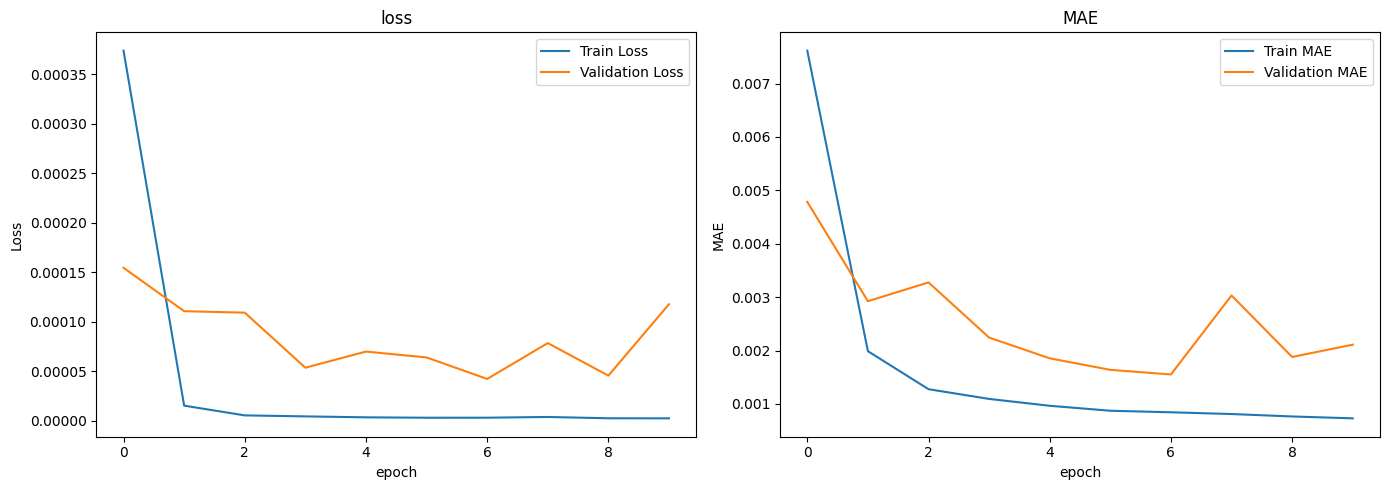

In [15]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE')
plt.xlabel('epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
print("Оценка на тестовых данных:")
loss, mae = model.evaluate(test_gen)
print(f"Test Loss: {loss:.4f}")
print(f"Test MAE: {mae:.4f}")

Оценка на тестовых данных:
28856/28856 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - loss: 3.2620e-05 - mae: 0.0012
Test Loss: 0.0000
Test MAE: 0.0016
